In [74]:
# !pip install pandas scikit-learn nltk gensim wordfreq transformer sentence-transformers SentencePiece textstat

In [75]:
from huggingface_hub import login
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForMaskedLM
from sentence_transformers import SentenceTransformer, util
from langchain_google_genai import ChatGoogleGenerativeAI
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
import torch
import spacy
import gensim.downloader as api
from wordfreq import zipf_frequency
import textstat
import os
import json

In [76]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Cuong
[nltk_data]     Ha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Cuong Ha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Cuong
[nltk_data]     Ha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [77]:
# Data from: https://sites.google.com/view/cwisharedtask2018/

# Format: 
# [ID] 
# [Sentence] 
# [Start Offset] 
# [End Offset] 
# [Target Word] 
# [Native Narrator Count] 
# [Non-Native Narrator Count] 
# [Native Narrator Marked Word As Difficult Count]
# [Non-Native Narrator Marked Word As Difficult Count]
# [Label for Binary Classification]
# [Label for Probabilistic Classification]

columns = [
    'id', 
    'sentence', 
    'start_offset', 
    'end_offset', 
    'complex_word', 
    'native_narrator_count',
    'non_native_narrator_count',    
    'native_narrator_marked_word_as_complex_count',
    'non_native_narrator_marked_word_as_complex_count',
    'label',
    'label_probs'
]
unused_columns = [
    'id', 
    'start_offset', 
    'end_offset', 
    'native_narrator_count',
    'non_native_narrator_count',    
    'native_narrator_marked_word_as_complex_count',
    'non_native_narrator_marked_word_as_complex_count',
    'label_probs'
]

def load_data(paths):
    df = None
    for path in paths:
        cwi_df = pd.read_csv(path, sep='\t', header=0)
        cwi_df.columns = columns
        if df is None:
            df = cwi_df
        else:
            df = pd.concat([df, cwi_df], ignore_index=True)
    df.drop(columns=unused_columns, inplace=True)
    df.dropna(inplace=True)
    return df

In [78]:
def count_syllables(word):
    vowels = 'aeiouy'
    word = word.lower()
    syllable_count = 0
    prev_char_was_vowel = False
    for char in word:
        if char in vowels:
            if not prev_char_was_vowel:
                syllable_count += 1
                prev_char_was_vowel = True
        else:
            prev_char_was_vowel = False
    if word.endswith('e'):
        syllable_count -= 1
    if syllable_count == 0:
        syllable_count = 1
    return syllable_count

In [79]:
def get_frequency(word):
    return zipf_frequency(word, 'en')

In [80]:
def get_word_length(word):
    return len(word)

In [81]:
def get_pos_tag(word, sentence):
    tokens = word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    for token, tag in tagged:
        if token.lower() == word.lower():
            return tag
    return 'NN'

In [82]:
def extract_features(df):
    df['word_length'] = df['complex_word'].apply(get_word_length)
    df['syllable_count'] = df['complex_word'].apply(count_syllables)
    df['frequency'] = df['complex_word'].apply(get_frequency)
    df['pos_tag'] = df.apply(lambda x: get_pos_tag(x['complex_word'], x['sentence']), axis=1)
    df = pd.concat([df, pd.get_dummies(df['pos_tag'])], axis=1)
    return df

In [83]:
train_data_paths = [
    'cwishareddataset/traindevset/english/News_Train.tsv',
    'cwishareddataset/traindevset/english/WikiNews_Train.tsv',
    'cwishareddataset/traindevset/english/Wikipedia_Train.tsv',
]

train_df = load_data(train_data_paths)
train_df = extract_features(train_df)
train_df

,sentence,complex_word,label,word_length,syllable_count,frequency,pos_tag,CC,CD,DT,...,RBR,RP,VB,VBD,VBG,VBN,VBP,VBZ,WP,WRB
0,"The barren islands, reefs and coral outcrops a...",barren islands,1,14,4,3.37,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"The barren islands, reefs and coral outcrops a...",reefs,1,5,1,3.36,NNS,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"The barren islands, reefs and coral outcrops a...",islands,0,7,2,4.50,VBZ,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,"The barren islands, reefs and coral outcrops a...",coral,0,5,2,3.86,JJ,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"The barren islands, reefs and coral outcrops a...",coral outcrops,1,14,4,2.75,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27291,An actor ( sometimes actress for female ; see ...,works,0,5,1,5.29,VBZ,False,False,False,...,False,False,False,False,False,False,False,True,False,False
27292,An actor ( sometimes actress for female ; see ...,film,0,4,1,5.20,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27293,An actor ( sometimes actress for female ; see ...,television,0,10,4,4.79,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
27294,An actor ( sometimes actress for female ; see ...,theater,0,7,2,4.35,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [84]:
dev_data_paths = [
    'cwishareddataset/traindevset/english/News_Dev.tsv',
    'cwishareddataset/traindevset/english/WikiNews_Dev.tsv',
    'cwishareddataset/traindevset/english/Wikipedia_Dev.tsv',
]

dev_df = load_data(dev_data_paths)
dev_df = extract_features(dev_df)
dev_df

,sentence,complex_word,label,word_length,syllable_count,frequency,pos_tag,CD,FW,IN,...,NNPS,NNS,RB,RP,VB,VBD,VBG,VBN,VBP,VBZ
0,Syrian troops shelled a rebel-held town on Mon...,Syrian,0,6,2,4.14,JJ,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Syrian troops shelled a rebel-held town on Mon...,shelled,1,7,2,3.08,VBD,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,Syrian troops shelled a rebel-held town on Mon...,rebel-held,1,10,3,4.05,JJ,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Syrian troops shelled a rebel-held town on Mon...,sparking,1,8,2,3.08,VBG,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,Syrian troops shelled a rebel-held town on Mon...,town,0,4,1,5.24,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3320,Devotion ( Bhakti ) will cancel the effects of...,knowledge,1,9,2,4.96,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3321,Devotion ( Bhakti ) will cancel the effects of...,person,0,6,2,5.55,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3322,Devotion ( Bhakti ) will cancel the effects of...,true,0,4,1,5.40,JJ,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3323,Devotion ( Bhakti ) will cancel the effects of...,purifying,1,9,3,2.77,VBG,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [85]:
test_data_paths = [
    'cwishareddataset/testset/english/News_Test.tsv',
    'cwishareddataset/testset/english/WikiNews_Test.tsv',
    'cwishareddataset/testset/english/Wikipedia_Test.tsv',
]

test_df = load_data(test_data_paths)
test_df = extract_features(test_df)
test_df

,sentence,complex_word,label,word_length,syllable_count,frequency,pos_tag,CD,IN,JJ,...,NNS,RB,RP,VB,VBD,VBG,VBN,VBP,VBZ,WP
0,"The teenage girl shot dead in Bellaghy, County...",teenage girl,0,12,4,4.12,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"The teenage girl shot dead in Bellaghy, County...",Londonderry,1,11,4,3.04,NNP,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,"The teenage girl shot dead in Bellaghy, County...",girl,0,4,1,5.38,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,"The teenage girl shot dead in Bellaghy, County...",shot,0,4,1,5.22,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,"The teenage girl shot dead in Bellaghy, County...",dead,0,4,1,5.19,JJ,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4244,"Quito , along with Kraków , were the first Wor...",Heritage,1,8,3,4.36,NNP,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4245,"Quito , along with Kraków , were the first Wor...",Heritage Sites,1,14,6,4.21,NN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4246,"Quito , along with Kraków , were the first Wor...",UNESCO,1,6,3,3.55,NNP,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4247,"Quito , along with Kraków , were the first Wor...",Sites,0,5,2,4.74,NNP,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [86]:
all_pos_tags = set(train_df['pos_tag'].unique()) | set(dev_df['pos_tag'].unique()) | set(test_df['pos_tag'].unique())

def align_features(df):
    for pos in all_pos_tags:
        if pos not in df.columns:
            df[pos] = 0
    return df

train_df = align_features(train_df)
dev_df = align_features(dev_df)
test_df = align_features(test_df)

In [87]:
feature_cols = ['word_length', 'syllable_count', 'frequency'] + list(train_df['pos_tag'].unique())

X_train = train_df[feature_cols]
y_train = train_df['label']

X_dev = dev_df[feature_cols]
y_dev = dev_df['label']

X_test = test_df[feature_cols]
y_test = test_df['label']

In [88]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

RandomForestClassifier()

In [89]:
y_dev_pred = clf.predict(X_dev)
print('Dev Set Classification Report:\n', classification_report(y_dev, y_dev_pred))

Dev Set Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.84      1939
           1       0.78      0.79      0.78      1386

    accuracy                           0.82      3325
   macro avg       0.81      0.81      0.81      3325
weighted avg       0.82      0.82      0.82      3325



In [90]:
y_pred = clf.predict(X_test)
print('Classification Report:\n', classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      2464
           1       0.80      0.77      0.79      1785

    accuracy                           0.82      4249
   macro avg       0.82      0.82      0.82      4249
weighted avg       0.82      0.82      0.82      4249



In [91]:
def get_user_level(word):
    frequency = get_frequency(word)
    if frequency >= 5.0:
        return 1  # Beginner
    elif 3.0 <= frequency < 5.0:
        return 2  # Intermediate
    else:
        return 3  # Expert

In [92]:
huggingface_access_key = os.environ.get('HF_ACCESS_TOKEN')
google_api_key = os.environ.get('GOOGLE_API_KEY')

login(token=huggingface_access_key)

In [93]:
# glove_model = api.load('glove-wiki-gigaword-100')

simplifier_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
simplifier_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
simplifier_model.eval()

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

nlp = spacy.load('en_core_web_sm')

# google_gemini = ChatGoogleGenerativeAI(model='gemini-1.5-flash')

# pipeline = transformers.pipeline('summarization', model='facebook/bart-large-cnn')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [94]:
def get_tokens_with_multi_word_expressions(sentence):
    doc = nlp(sentence)
    tokens = []
    skip_tokens = set()
    for token in doc:
        if token.i in skip_tokens:
            continue
        # Check for compound nouns
        if token.dep_ == 'compound' and token.head.pos_ == 'NOUN':
            # Combine compound and its head noun
            compound_noun = token.text + ' ' + token.head.text
            tokens.append(compound_noun)
            skip_tokens.add(token.head.i)
        else:
            tokens.append(token.text)
    return tokens

In [95]:
def is_antonym(word1, word2):
    antonyms = set()
    for syn in wordnet.synsets(word1):
        for lemma in syn.lemmas():
            for antonym in lemma.antonyms():
                antonyms.add(antonym.name().lower())
    return word2.lower() in antonyms

In [96]:
def find_synonyms_with_context(word, sentence, user_level):
    # Mask the complex word in the sentence
    masked_sentence = sentence.replace(word, '[MASK]')
    inputs = simplifier_tokenizer.encode_plus(sentence, masked_sentence, add_special_tokens=True, return_tensors='pt')
    mask_token_index = torch.where(inputs['input_ids'][0] == simplifier_tokenizer.mask_token_id)[0]
    
    if len(mask_token_index) == 0:
        return []
    
    with torch.no_grad():
        outputs = simplifier_model(**inputs)
    logits = outputs.logits

    # Get the top 20 predictions for the masked token
    top_k = 20
    mask_token_logits = logits[0, mask_token_index, :]
    top_tokens = torch.topk(mask_token_logits, top_k, dim=1).indices[0].tolist()

    # Decode the tokens and filter based on user level and their simplicity compared against the original word
    synonyms = []
    for token in top_tokens:
        synonym = simplifier_tokenizer.decode([token]).strip()
        if is_antonym(word.lower(), synonym.lower()):
            continue
        # POS Tagging to ensure grammatical consistency
        original_pos = get_pos_tag(word, sentence)
        synonym_pos = get_pos_tag(synonym.lower(), sentence.replace(word, synonym.lower()))
        if original_pos != synonym_pos:
            continue
        # Check if the synonym is more common than original word
        is_simpler = get_frequency(synonym.lower()) >= get_frequency(word.lower())
        # Semantic similarity check
        synonym_sentence = sentence.replace(word, synonym.lower())
        embedding_original = sbert_model.encode(sentence, convert_to_tensor=True)
        embedding_synonym = sbert_model.encode(synonym_sentence, convert_to_tensor=True)
        similarity = util.pytorch_cos_sim(embedding_original, embedding_synonym).item()
        # Accept a synonym if it meets the requirements
        if similarity >= 0.8 and is_simpler and get_user_level(synonym) <= user_level:
            synonyms.append((synonym, get_frequency(synonym.lower()), similarity))
    # Sort synonyms by similarity then by frequency
    synonyms.sort(key=lambda x: (-x[2], -x[1]))
    
    # Return only the synonyms
    return [syn[0] for syn in synonyms]

In [97]:
def simplify_text(text, user_level):
    sentences = nltk.sent_tokenize(text)
    result_text = ''
    for sentence in sentences:
        # tokens = word_tokenize(sentence)
        tokens = get_tokens_with_multi_word_expressions(sentence)
        new_sentence = ''
        for word in tokens:
            # Ignore punctuation
            if not word.isalpha():
                new_sentence += word + ' '
                continue
            # Extract features for the word
            word_features = {
                'word_length': get_word_length(word),
                'syllable_count': count_syllables(word),
                'frequency': get_frequency(word),
                'pos_tag': get_pos_tag(word, sentence)
            }
            # One-hot encode POS tag
            for pos in all_pos_tags:
                word_features[pos] = 1 if word_features['pos_tag'] == pos else 0
            # Create DataFrame
            word_df = pd.DataFrame([word_features])
            # Select feature columns
            word_X = word_df[feature_cols]
            # Predict complexity
            is_complex = clf.predict(word_X)[0]
            if is_complex:
                # Find synonyms
                synonyms = find_synonyms_with_context(word, sentence, user_level)
                # synonyms = find_synonyms(word, sentence, user_level)
                if synonyms:
                    # Replace word with the first suitable synonym
                    word = synonyms[0]
            new_sentence += word + ' '
        result_text += new_sentence.strip() + ' '
    return result_text.strip()

In [98]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-small-finetuned-text-simplification")
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-small-finetuned-text-simplification")

In [99]:
def summarize_text(text):
    input = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model.generate(**input, max_length=1024)
    simplified_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return simplified_text

In [100]:
# def summarize_text(simplified_text, user_level):
#     if user_level == 1:
#         prompt = f'Understanding level: Beginner. Summarize: {simplified_text}'
#     elif user_level == 2:
#         prompt = f'Understanding level: Intermediate. Summarize: {simplified_text}'
#     else:
#         prompt = f'Understanding level: Expert. Summarize: {simplified_text}'
#     return google_gemini.invoke(prompt).content

In [101]:
def overall_pipeline(text, user_level):
    simplified_text = simplify_text(text, user_level)
    # print(f'Original Text:\n{text}')
    # print(f'Simplified Text:\n{simplified_text}')
    summarized_text = summarize_text(simplified_text)
    # summarized_text = summarize_text(simplified_text, user_level)
    # print(f'Summarized Simplified Text:\n{summarized_text}')
    # print('*' * 100,'\n')
    return summarized_text

In [102]:
user_level = 1  # Beginner
# user_level = 2  # Intermediate
# user_level = 3  # Expert

In [103]:
statements1 = pd.read_csv('statements/complex_statements_1.csv')
statements2 = pd.read_csv('statements/complex_statements_2.csv')
statements3 = pd.read_csv('statements/complex_statements_3.csv')
statements4 = pd.read_csv('statements/complex_statements_4.csv')
statements5 = pd.read_csv('statements/complex_statements_5.csv')
statements6 = pd.read_csv('statements/complex_statements_6.csv')
statements7 = pd.read_csv('statements/complex_statements_7.csv')
statements8 = pd.read_csv('statements/complex_statements_8.csv')
statements9 = pd.read_csv('statements/complex_statements_9.csv')
statements10 = pd.read_csv('statements/complex_statements_10.csv')

In [104]:
# generate1 = 1
# generate2 = 1
# generate3 = 1
# generate4 = 1
# generate5 = 1
# generate6 = 1
# generate7 = 1
# generate8 = 1
# generate9 = 1
# generate10 = 1

generate1 = 0
generate2 = 0
generate3 = 0
generate4 = 0
generate5 = 0
generate6 = 0
generate7 = 0
generate8 = 0
generate9 = 0
generate10 = 0

In [105]:
results1 = []

if generate1:
    for index, sentence in enumerate(statements1['sentences']):
        if (index + 1) % 5 == 0:
            print(f'Progress: {index + 1}/{len(statements1)}')
        output = overall_pipeline(sentence, user_level)
        results1.append({
            'original_sentence': sentence,
            'simplified_sentence': output,
            'simplified_level': user_level,
            'fkgl_original': textstat.flesch_kincaid_grade(sentence),
            'fre_original': textstat.flesch_reading_ease(sentence),
            'fkgl_simplified': textstat.flesch_kincaid_grade(output),
            'fre_simplified': textstat.flesch_reading_ease(output),
        })
    with open('results/result_1.json', 'w') as f:
        json.dump(results1, f, indent=4)

In [106]:
results2 = []

if generate2:
    for index, sentence in enumerate(statements2['sentences']):
        if (index + 1) % 5 == 0:
            print(f'Progress: {index + 1}/{len(statements2)}')
        output = overall_pipeline(sentence, user_level)
        results2.append({
            'original_sentence': sentence,
            'simplified_sentence': output,
            'simplified_level': user_level,
            'fkgl_original': textstat.flesch_kincaid_grade(sentence),
            'fre_original': textstat.flesch_reading_ease(sentence),
            'fkgl_simplified': textstat.flesch_kincaid_grade(output),
            'fre_simplified': textstat.flesch_reading_ease(output),
        })
    with open('results/result_2.json', 'w') as f:
        json.dump(results2, f, indent=4)

In [107]:
results3 = []

if generate3:
    for index, sentence in enumerate(statements3['sentences']):
        if (index + 1) % 5 == 0:
            print(f'Progress: {index + 1}/{len(statements3)}')
        output = overall_pipeline(sentence, user_level)
        results3.append({
            'original_sentence': sentence,
            'simplified_sentence': output,
            'simplified_level': user_level,
            'fkgl_original': textstat.flesch_kincaid_grade(sentence),
            'fre_original': textstat.flesch_reading_ease(sentence),
            'fkgl_simplified': textstat.flesch_kincaid_grade(output),
            'fre_simplified': textstat.flesch_reading_ease(output),
        })
    with open('results/result_3.json', 'w') as f:
        json.dump(results3, f, indent=4)

In [108]:
results4 = []

if generate4:
    for index, sentence in enumerate(statements4['sentences']):
        if (index + 1) % 5 == 0:
            print(f'Progress: {index + 1}/{len(statements4)}')
        output = overall_pipeline(sentence, user_level)
        results4.append({
            'original_sentence': sentence,
            'simplified_sentence': output,
            'simplified_level': user_level,
            'fkgl_original': textstat.flesch_kincaid_grade(sentence),
            'fre_original': textstat.flesch_reading_ease(sentence),
            'fkgl_simplified': textstat.flesch_kincaid_grade(output),
            'fre_simplified': textstat.flesch_reading_ease(output),
        })
    with open('results/result_4.json', 'w') as f:
        json.dump(results4, f, indent=4)

In [109]:
results5 = []

if generate5:
    for index, sentence in enumerate(statements5['sentences']):
        if (index + 1) % 5 == 0:
            print(f'Progress: {index + 1}/{len(statements5)}')
        output = overall_pipeline(sentence, user_level)
        results5.append({
            'original_sentence': sentence,
            'simplified_sentence': output,
            'simplified_level': user_level,
            'fkgl_original': textstat.flesch_kincaid_grade(sentence),
            'fre_original': textstat.flesch_reading_ease(sentence),
            'fkgl_simplified': textstat.flesch_kincaid_grade(output),
            'fre_simplified': textstat.flesch_reading_ease(output),
        })
    with open('results/result_5.json', 'w') as f:
        json.dump(results5, f, indent=4)

In [110]:
results6 = []

if generate6:
    for index, sentence in enumerate(statements6['sentences']):
        if (index + 1) % 5 == 0:
            print(f'Progress: {index + 1}/{len(statements6)}')
        output = overall_pipeline(sentence, user_level)
        results6.append({
            'original_sentence': sentence,
            'simplified_sentence': output,
            'simplified_level': user_level,
            'fkgl_original': textstat.flesch_kincaid_grade(sentence),
            'fre_original': textstat.flesch_reading_ease(sentence),
            'fkgl_simplified': textstat.flesch_kincaid_grade(output),
            'fre_simplified': textstat.flesch_reading_ease(output),
        })
    with open('results/result_6.json', 'w') as f:
        json.dump(results6, f, indent=4)

In [111]:
results7 = []

if generate7:
    for index, sentence in enumerate(statements7['sentences']):
        if (index + 1) % 5 == 0:
            print(f'Progress: {index + 1}/{len(statements7)}')
        output = overall_pipeline(sentence, user_level)
        results7.append({
            'original_sentence': sentence,
            'simplified_sentence': output,
            'simplified_level': user_level,
            'fkgl_original': textstat.flesch_kincaid_grade(sentence),
            'fre_original': textstat.flesch_reading_ease(sentence),
            'fkgl_simplified': textstat.flesch_kincaid_grade(output),
            'fre_simplified': textstat.flesch_reading_ease(output),
        })
    with open('results/result_7.json', 'w') as f:
        json.dump(results7, f, indent=4)

In [112]:
results8 = []

if generate8:
    for index, sentence in enumerate(statements8['sentences']):
        if (index + 1) % 5 == 0:
            print(f'Progress: {index + 1}/{len(statements8)}')
        output = overall_pipeline(sentence, user_level)
        results8.append({
            'original_sentence': sentence,
            'simplified_sentence': output,
            'simplified_level': user_level,
            'fkgl_original': textstat.flesch_kincaid_grade(sentence),
            'fre_original': textstat.flesch_reading_ease(sentence),
            'fkgl_simplified': textstat.flesch_kincaid_grade(output),
            'fre_simplified': textstat.flesch_reading_ease(output),
        })
    with open('results/result_8.json', 'w') as f:
        json.dump(results8, f, indent=4)

In [113]:
results9 = []

if generate9:
    for index, sentence in enumerate(statements9['sentences']):
        if (index + 1) % 5 == 0:
            print(f'Progress: {index + 1}/{len(statements9)}')
        output = overall_pipeline(sentence, user_level)
        results9.append({
            'original_sentence': sentence,
            'simplified_sentence': output,
            'simplified_level': user_level,
            'fkgl_original': textstat.flesch_kincaid_grade(sentence),
            'fre_original': textstat.flesch_reading_ease(sentence),
            'fkgl_simplified': textstat.flesch_kincaid_grade(output),
            'fre_simplified': textstat.flesch_reading_ease(output),
        })
    with open('results/result_9.json', 'w') as f:
        json.dump(results9, f, indent=4)

In [114]:
results10 = []

if generate10:
    for index, sentence in enumerate(statements10['sentences']):
        if (index + 1) % 5 == 0:
            print(f'Progress: {index + 1}/{len(statements10)}')
        output = overall_pipeline(sentence, user_level)
        results10.append({
            'original_sentence': sentence,
            'simplified_sentence': output,
            'simplified_level': user_level,
            'fkgl_original': textstat.flesch_kincaid_grade(sentence),
            'fre_original': textstat.flesch_reading_ease(sentence),
            'fkgl_simplified': textstat.flesch_kincaid_grade(output),
            'fre_simplified': textstat.flesch_reading_ease(output),
        })
    with open('results/result_10.json', 'w') as f:
        json.dump(results10, f, indent=4)

In [115]:
# combined_results = []

# for i in range(10):
#     with open(f'results/result_{i + 1}.json', 'r') as f:
#         combined_results += json.load(f)

# results_df = pd.DataFrame(combined_results)
# results_df

In [116]:
# fkgl_original_mean = results_df['fkgl_original'].mean()
# fre_original_mean = results_df['fre_original'].mean()
# fkgl_simplified_mean = results_df['fkgl_simplified'].mean()
# fre_simplified_mean = results_df['fre_simplified'].mean()

In [117]:
# print(f'FKGL Orignal Mean: {fkgl_original_mean:0.2f}')
# print(f'FRE Orignal Mean: {fre_original_mean:0.2f}')
# print(f'FKGL Simplified Mean: {fkgl_simplified_mean:0.2f}')
# print(f'FRE Simplified Mean: {fre_simplified_mean:0.2f}')

In [118]:
models = [
    {
        'name': 't5-small',
        'tokenizer': 'T5Tokenizer',
        'model': 'T5ForConditionalGeneration'
    },
    {
        'name': 't5-base',
        'tokenizer': 'T5Tokenizer',
        'model': 'T5ForConditionalGeneration'
    },
    {
        'name': 'facebook/bart-base',
        'tokenizer': 'BartTokenizer',
        'model': 'BartForConditionalGeneration'
    },
    {
        'name': 'facebook/bart-large',
        'tokenizer': 'BartTokenizer',
        'model': 'BartForConditionalGeneration'
    },
    {
        'name': 'google/pegasus-xsum',
        'tokenizer': 'PegasusTokenizer',
        'model': 'PegasusForConditionalGeneration'
    }
]

In [119]:
def simplify_text_existing_model(text, user_level, model, tokenizer):
    if user_level == 1:
        input_text = "Understanding level: Beginner. Simplify: " + text
    elif user_level == 2:
        input_text = "Understanding level: Intermediate. Simplify: " + text
    else:
        input_text = "Understanding level: Expert. Simplify: " + text
    input_ids = tokenizer.encode(input_text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model.generate(
        input_ids,
        max_length=512,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )
    simplified_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return simplified_text

In [120]:
test = 0

def generate_existing(model, tokenizer, model_name, dataset=0):

    if dataset == 0 or dataset == 1:
        results = []
        for index, sentence in enumerate(statements1['sentences']):
            if (index + 1) % 5 == 0:
                print(f'Progress: {index + 1}/{len(statements1)}')
            output = simplify_text_existing_model(sentence, user_level, model, tokenizer)
            results.append({
                'original_sentence': sentence,
                'simplified_sentence': output,
                'simplified_level': user_level,
                'fkgl_original': textstat.flesch_kincaid_grade(sentence),
                'fre_original': textstat.flesch_reading_ease(sentence),
                'fkgl_simplified': textstat.flesch_kincaid_grade(output),
                'fre_simplified': textstat.flesch_reading_ease(output),
            })
            if test: break
        with open(f'results/{model_name}/result_1.json', 'w') as f:
            json.dump(results, f, indent=4)

    if dataset == 0 or dataset == 2:
        results = []
        for index, sentence in enumerate(statements2['sentences']):
            if (index + 1) % 5 == 0:
                print(f'Progress: {index + 1}/{len(statements2)}')
            output = simplify_text_existing_model(sentence, user_level, model, tokenizer)
            results.append({
                'original_sentence': sentence,
                'simplified_sentence': output,
                'simplified_level': user_level,
                'fkgl_original': textstat.flesch_kincaid_grade(sentence),
                'fre_original': textstat.flesch_reading_ease(sentence),
                'fkgl_simplified': textstat.flesch_kincaid_grade(output),
                'fre_simplified': textstat.flesch_reading_ease(output),
            })
            if test: break
        with open(f'results/{model_name}/result_2.json', 'w') as f:
            json.dump(results, f, indent=4)

    if dataset == 0 or dataset == 3:
        results = []
        for index, sentence in enumerate(statements3['sentences']):
            if (index + 1) % 5 == 0:
                print(f'Progress: {index + 1}/{len(statements3)}')
            output = simplify_text_existing_model(sentence, user_level, model, tokenizer)
            results.append({
                'original_sentence': sentence,
                'simplified_sentence': output,
                'simplified_level': user_level,
                'fkgl_original': textstat.flesch_kincaid_grade(sentence),
                'fre_original': textstat.flesch_reading_ease(sentence),
                'fkgl_simplified': textstat.flesch_kincaid_grade(output),
                'fre_simplified': textstat.flesch_reading_ease(output),
            })
            if test: break
        with open(f'results/{model_name}/result_3.json', 'w') as f:
            json.dump(results, f, indent=4)

    if dataset == 0 or dataset == 4:
        results = []
        for index, sentence in enumerate(statements4['sentences']):
            if (index + 1) % 5 == 0:
                print(f'Progress: {index + 1}/{len(statements4)}')
            output = simplify_text_existing_model(sentence, user_level, model, tokenizer)
            results.append({
                'original_sentence': sentence,
                'simplified_sentence': output,
                'simplified_level': user_level,
                'fkgl_original': textstat.flesch_kincaid_grade(sentence),
                'fre_original': textstat.flesch_reading_ease(sentence),
                'fkgl_simplified': textstat.flesch_kincaid_grade(output),
                'fre_simplified': textstat.flesch_reading_ease(output),
            })
            if test: break
        with open(f'results/{model_name}/result_4.json', 'w') as f:
            json.dump(results, f, indent=4)

    if dataset == 0 or dataset == 5:
        results = []
        for index, sentence in enumerate(statements5['sentences']):
            if (index + 1) % 5 == 0:
                print(f'Progress: {index + 1}/{len(statements5)}')
            output = simplify_text_existing_model(sentence, user_level, model, tokenizer)
            results.append({
                'original_sentence': sentence,
                'simplified_sentence': output,
                'simplified_level': user_level,
                'fkgl_original': textstat.flesch_kincaid_grade(sentence),
                'fre_original': textstat.flesch_reading_ease(sentence),
                'fkgl_simplified': textstat.flesch_kincaid_grade(output),
                'fre_simplified': textstat.flesch_reading_ease(output),
            })
            if test: break
        with open(f'results/{model_name}/result_5.json', 'w') as f:
            json.dump(results, f, indent=4)

    if dataset == 0 or dataset == 6:
        results = []
        for index, sentence in enumerate(statements6['sentences']):
            if (index + 1) % 5 == 0:
                print(f'Progress: {index + 1}/{len(statements6)}')
            output = simplify_text_existing_model(sentence, user_level, model, tokenizer)
            results.append({
                'original_sentence': sentence,
                'simplified_sentence': output,
                'simplified_level': user_level,
                'fkgl_original': textstat.flesch_kincaid_grade(sentence),
                'fre_original': textstat.flesch_reading_ease(sentence),
                'fkgl_simplified': textstat.flesch_kincaid_grade(output),
                'fre_simplified': textstat.flesch_reading_ease(output),
            })
            if test: break
        with open(f'results/{model_name}/result_6.json', 'w') as f:
            json.dump(results, f, indent=4)

    if dataset == 0 or dataset == 7:
        results = []
        for index, sentence in enumerate(statements7['sentences']):
            if (index + 1) % 5 == 0:
                print(f'Progress: {index + 1}/{len(statements7)}')
            output = simplify_text_existing_model(sentence, user_level, model, tokenizer)
            results.append({
                'original_sentence': sentence,
                'simplified_sentence': output,
                'simplified_level': user_level,
                'fkgl_original': textstat.flesch_kincaid_grade(sentence),
                'fre_original': textstat.flesch_reading_ease(sentence),
                'fkgl_simplified': textstat.flesch_kincaid_grade(output),
                'fre_simplified': textstat.flesch_reading_ease(output),
            })
            if test: break
        with open(f'results/{model_name}/result_7.json', 'w') as f:
            json.dump(results, f, indent=4)

    if dataset == 0 or dataset == 8:
        results = []
        for index, sentence in enumerate(statements8['sentences']):
            if (index + 1) % 5 == 0:
                print(f'Progress: {index + 1}/{len(statements8)}')
            output = simplify_text_existing_model(sentence, user_level, model, tokenizer)
            results.append({
                'original_sentence': sentence,
                'simplified_sentence': output,
                'simplified_level': user_level,
                'fkgl_original': textstat.flesch_kincaid_grade(sentence),
                'fre_original': textstat.flesch_reading_ease(sentence),
                'fkgl_simplified': textstat.flesch_kincaid_grade(output),
                'fre_simplified': textstat.flesch_reading_ease(output),
            })
            if test: break
        with open(f'results/{model_name}/result_8.json', 'w') as f:
            json.dump(results, f, indent=4)

    if dataset == 0 or dataset == 9:
        results = []
        for index, sentence in enumerate(statements9['sentences']):
            if (index + 1) % 5 == 0:
                print(f'Progress: {index + 1}/{len(statements9)}')
            output = simplify_text_existing_model(sentence, user_level, model, tokenizer)
            results.append({
                'original_sentence': sentence,
                'simplified_sentence': output,
                'simplified_level': user_level,
                'fkgl_original': textstat.flesch_kincaid_grade(sentence),
                'fre_original': textstat.flesch_reading_ease(sentence),
                'fkgl_simplified': textstat.flesch_kincaid_grade(output),
                'fre_simplified': textstat.flesch_reading_ease(output),
            })
            if test: break
        with open(f'results/{model_name}/result_9.json', 'w') as f:
            json.dump(results, f, indent=4)

    if dataset == 0 or dataset == 10:
        results = []
        for index, sentence in enumerate(statements10['sentences']):
            if (index + 1) % 5 == 0:
                print(f'Progress: {index + 1}/{len(statements10)}')
            output = simplify_text_existing_model(sentence, user_level, model, tokenizer)
            results.append({
                'original_sentence': sentence,
                'simplified_sentence': output,
                'simplified_level': user_level,
                'fkgl_original': textstat.flesch_kincaid_grade(sentence),
                'fre_original': textstat.flesch_reading_ease(sentence),
                'fkgl_simplified': textstat.flesch_kincaid_grade(output),
                'fre_simplified': textstat.flesch_reading_ease(output),
            })
            if test: break
        with open(f'results/{model_name}/result_10.json', 'w') as f:
            json.dump(results, f, indent=4)

In [121]:
# generate_existing_1 = 1
# generate_existing_2 = 1
# generate_existing_3 = 1
# generate_existing_4 = 1
# generate_existing_5 = 1

generate_existing_1 = 0
generate_existing_2 = 0
generate_existing_3 = 0
generate_existing_4 = 0
generate_existing_5 = 0

In [122]:
if generate_existing_1:
    t5_small_tokenizer_class  = globals()[models[0]['tokenizer']]
    t5_small_model_class = globals()[models[0]['model']]

    t5_small_tokenizer = t5_small_tokenizer_class.from_pretrained(models[0]['name'])
    t5_small_model = t5_small_model_class.from_pretrained(models[0]['name'])

    simplified_sentences = generate_existing(t5_small_model, t5_small_tokenizer, 't5_small', dataset=0)

In [123]:
if generate_existing_2:
    t5_base_tokenizer_class  = globals()[models[1]['tokenizer']]
    t5_base_model_class = globals()[models[1]['model']]

    t5_base_tokenizer = t5_base_tokenizer_class.from_pretrained(models[1]['name'])
    t5_base_model = t5_base_model_class.from_pretrained(models[1]['name'])

    simplified_sentences = generate_existing(t5_base_model, t5_base_tokenizer, 't5_base', dataset=0)

In [124]:
if generate_existing_3:
    bart_base_tokenizer_class  = globals()[models[2]['tokenizer']]
    bart_base_model_class = globals()[models[2]['model']]

    bart_base_tokenizer = bart_base_tokenizer_class.from_pretrained(models[2]['name'])
    bart_base_model = bart_base_model_class.from_pretrained(models[2]['name'])

    simplified_sentences = generate_existing(bart_base_model, bart_base_tokenizer, 'bart_base', dataset=0)

In [125]:
if generate_existing_4:
    bart_large_tokenizer_class  = globals()[models[3]['tokenizer']]
    bart_large_model_class = globals()[models[3]['model']]

    bart_large_tokenizer = bart_large_tokenizer_class.from_pretrained(models[3]['name'])
    bart_large_model = bart_large_model_class.from_pretrained(models[3]['name'])

    simplified_sentences = generate_existing(bart_large_model, bart_large_tokenizer, 'bart_large', dataset=0)

In [126]:
if generate_existing_5:
    pegasus_xsum_tokenizer_class  = globals()[models[4]['tokenizer']]
    pegasus_xsum_model_class = globals()[models[4]['model']]

    pegasus_xsum_tokenizer = pegasus_xsum_tokenizer_class.from_pretrained(models[4]['name'])
    pegasus_xsum_model = pegasus_xsum_model_class.from_pretrained(models[4]['name'])

    simplified_sentences = generate_existing(pegasus_xsum_model, pegasus_xsum_tokenizer, 'pegasus_xsum', dataset=0)

In [127]:
combined_results = []

for i in range(10):
    with open(f'results/result_{i + 1}.json', 'r') as f:
        combined_results += json.load(f)

results_df = pd.DataFrame(combined_results)
results_df

,original_sentence,simplified_sentence,simplified_level,fkgl_original,fre_original,fkgl_simplified,fre_simplified
0,In a society driven predominantly by individua...,In a society run predominantly by individual p...,1,26.8,-43.58,19.3,13.62
1,The ontological distinctions between deontolog...,The ontological distinctions between deontolog...,1,28.8,-59.49,20.5,-0.27
2,The ethical ramifications of anthropogenic cli...,The human issues of current climate change con...,1,26.8,-49.00,15.0,35.61
3,Philosophical discourses surrounding the ontol...,Other issues surrounding the idea of personhoo...,1,29.6,-77.76,17.0,14.29
4,The dialectical tension between consequentiali...,The specific position between consequentialist...,1,27.2,-55.43,22.1,-15.16
...,...,...,...,...,...,...,...
495,"The philosophical exploration of epistemology,...","The social study of experience , especially th...",1,26.3,-4.66,15.8,39.00
496,"The rise of the Hellenistic empires, following...","The rise of the Hellenistic countries , follow...",1,25.1,14.64,22.4,32.57
497,The intellectual contributions of Renaissance ...,"The social works of Renaissance humanism , whi...",1,27.9,-19.55,25.9,-3.65
498,The rise of the avant-garde in 20th-century ar...,The rise of the art - garde in 20th century ar...,1,26.3,-4.66,22.4,27.16


In [128]:
combined_results_t5_small = []

for i in range(10):
    with open(f'results/t5_small/result_{i + 1}.json', 'r') as f:
        combined_results_t5_small += json.load(f)

results_t5_small_df = pd.DataFrame(combined_results_t5_small)
results_t5_small_df

,original_sentence,simplified_sentence,simplified_level,fkgl_original,fre_original,fkgl_simplified,fre_simplified
0,In a society driven predominantly by individua...,level: Beginner. Simplify: In a society driven...,1,26.8,-43.58,28.0,-46.63
1,The ontological distinctions between deontolog...,level: Beginner. Simplify: The ontological dis...,1,28.8,-59.49,29.9,-62.53
2,The ethical ramifications of anthropogenic cli...,the ethical ramifications of anthropogenic cli...,1,26.8,-49.00,26.8,-49.00
3,Philosophical discourses surrounding the ontol...,level: Beginner. Simplify: Philosophical disco...,1,29.6,-77.76,29.6,-72.35
4,The dialectical tension between consequentiali...,level: Beginner. Simplify: The dialectical ten...,1,27.2,-55.43,28.4,-58.47
...,...,...,...,...,...,...,...
495,"The philosophical exploration of epistemology,...",understanding level: Beginner. Simplify: The p...,1,26.3,-4.66,18.5,10.23
496,"The rise of the Hellenistic empires, following...",: Beginner. Simplify: The rise of the Hellenis...,1,25.1,14.64,15.0,35.61
497,The intellectual contributions of Renaissance ...,: Beginner. Simplify: The intellectual contrib...,1,27.9,-19.55,28.7,-27.00
498,The rise of the avant-garde in 20th-century ar...,Simplify: The rise of the avant-garde in 20th-...,1,26.3,-4.66,25.9,-3.65


In [129]:
combined_results_t5_base = []

for i in range(10):
    with open(f'results/t5_base/result_{i + 1}.json', 'r') as f:
        combined_results_t5_base += json.load(f)

results_t5_base_df = pd.DataFrame(combined_results_t5_base)
results_t5_base_df

,original_sentence,simplified_sentence,simplified_level,fkgl_original,fre_original,fkgl_simplified,fre_simplified
0,In a society driven predominantly by individua...,False,1,26.8,-43.58,-3.5,121.22
1,The ontological distinctions between deontolog...,False,1,28.8,-59.49,-3.5,121.22
2,The ethical ramifications of anthropogenic cli...,Level: Beginner.,1,26.8,-49.00,14.7,-6.70
3,Philosophical discourses surrounding the ontol...,Simple,1,29.6,-77.76,8.4,36.62
4,The dialectical tension between consequentiali...,False,1,27.2,-55.43,-3.5,121.22
...,...,...,...,...,...,...,...
495,"The philosophical exploration of epistemology,...",Understanding level: Beginner,1,26.3,-4.66,21.0,-50.02
496,"The rise of the Hellenistic empires, following...","Greek culture, philosophy, and science spread ...",1,25.1,14.64,7.2,66.74
497,The intellectual contributions of Renaissance ...,: Intermediate.: Beginner. Simplify: The intel...,1,27.9,-19.55,25.6,-29.71
498,The rise of the avant-garde in 20th-century ar...,False,1,26.3,-4.66,-3.5,121.22


In [130]:
combined_results_bart_base = []

for i in range(10):
    with open(f'results/bart_base/result_{i + 1}.json', 'r') as f:
        combined_results_bart_base += json.load(f)

results_bart_base_df = pd.DataFrame(combined_results_bart_base)
results_bart_base_df

,original_sentence,simplified_sentence,simplified_level,fkgl_original,fre_original,fkgl_simplified,fre_simplified
0,In a society driven predominantly by individua...,Understanding level: Beginner. Simplify: In a ...,1,26.8,-43.58,22.9,-38.85
1,The ontological distinctions between deontolog...,Understanding level: Beginner. Simplify: The o...,1,28.8,-59.49,23.9,-46.80
2,The ethical ramifications of anthropogenic cli...,Understanding level: Beginner. Simplify: The e...,1,26.8,-49.00,23.5,-45.79
3,Philosophical discourses surrounding the ontol...,Understanding level: Beginner. Simplify: Philo...,1,29.6,-77.76,26.1,-68.63
4,The dialectical tension between consequentiali...,Understanding level: Beginner. Simplify: The d...,1,27.2,-55.43,23.1,-44.77
...,...,...,...,...,...,...,...
495,"The philosophical exploration of epistemology,...",Understanding level: Beginner. Simplify: The p...,1,26.3,-4.66,18.5,10.23
496,"The rise of the Hellenistic empires, following...",Understanding level: Beginner. Simplify: The r...,1,25.1,14.64,16.2,32.57
497,The intellectual contributions of Renaissance ...,Understanding level: Beginner. Simplify: The i...,1,27.9,-19.55,19.9,-4.16
498,The rise of the avant-garde in 20th-century ar...,Understanding level: Beginner. Simplify: The r...,1,26.3,-4.66,17.2,19.20


In [131]:
combined_results_bart_large = []

for i in range(10):
    with open(f'results/bart_large/result_{i + 1}.json', 'r') as f:
        combined_results_bart_large += json.load(f)

results_bart_large_df = pd.DataFrame(combined_results_bart_large)
results_bart_large_df

,original_sentence,simplified_sentence,simplified_level,fkgl_original,fre_original,fkgl_simplified,fre_simplified
0,In a society driven predominantly by individua...,Understanding level: Beginner. Simplify: In a ...,1,26.8,-43.58,22.9,-38.85
1,The ontological distinctions between deontolog...,Understanding level: Beginner. Simplify: The o...,1,28.8,-59.49,23.9,-46.80
2,The ethical ramifications of anthropogenic cli...,Understanding level: Beginner. Simplify: The e...,1,26.8,-49.00,23.5,-45.79
3,Philosophical discourses surrounding the ontol...,Understanding level: Beginner. Simplify: Philo...,1,29.6,-77.76,26.1,-68.63
4,The dialectical tension between consequentiali...,Understanding level: Beginner. Simplify: The d...,1,27.2,-55.43,23.1,-44.77
...,...,...,...,...,...,...,...
495,"The philosophical exploration of epistemology,...",Understanding level: Beginner. Simplify: The p...,1,26.3,-4.66,18.5,10.23
496,"The rise of the Hellenistic empires, following...",Understanding level: Beginner. Simplify: The r...,1,25.1,14.64,16.0,33.07
497,The intellectual contributions of Renaissance ...,Understanding level: Beginner. Simplify: The i...,1,27.9,-19.55,20.3,-5.18
498,The rise of the avant-garde in 20th-century ar...,Understanding level: Beginner. Simplify: The r...,1,26.3,-4.66,17.8,17.68


In [132]:
combined_results_pegasus_xsum = []

for i in range(10):
    with open(f'results/pegasus_xsum/result_{i + 1}.json', 'r') as f:
        combined_results_pegasus_xsum += json.load(f)

results_pegasus_xsum_df = pd.DataFrame(combined_results_pegasus_xsum)
results_pegasus_xsum_df

,original_sentence,simplified_sentence,simplified_level,fkgl_original,fre_original,fkgl_simplified,fre_simplified
0,In a society driven predominantly by individua...,This course aims to provide students with a ba...,1,26.8,-43.58,14.2,26.81
1,The ontological distinctions between deontolog...,This course aims to introduce students to the ...,1,28.8,-59.49,13.1,29.86
2,The ethical ramifications of anthropogenic cli...,"Key words: climate change, ethics.",1,26.8,-49.00,0.5,100.24
3,Philosophical discourses surrounding the ontol...,The role of human beings in the development of...,1,29.6,-77.76,12.3,26.47
4,The dialectical tension between consequentiali...,This course is designed for students with litt...,1,27.2,-55.43,8.8,57.27
...,...,...,...,...,...,...,...
495,"The philosophical exploration of epistemology,...",In our series of letters from African journali...,1,26.3,-4.66,13.0,46.10
496,"The rise of the Hellenistic empires, following...",The Hellenistic world was a period of profound...,1,25.1,14.64,21.2,24.79
497,The intellectual contributions of Renaissance ...,"Key words: Renaissance, humanism, philosophy.",1,27.9,-19.55,14.7,-1.29
498,The rise of the avant-garde in 20th-century ar...,This course is designed for students who are n...,1,26.3,-4.66,4.0,91.11


In [133]:
fkgl_original_mean = results_df['fkgl_original'].mean()
fre_original_mean = results_df['fre_original'].mean()

In [134]:
fkgl_simplified_mean = results_df['fkgl_simplified'].mean()
fre_simplified_mean = results_df['fre_simplified'].mean()

In [135]:
fkgl_t5_small_mean = results_t5_small_df['fkgl_simplified'].mean()
fre_t5_small_mean = results_t5_small_df['fre_simplified'].mean()

In [136]:
fkgl_t5_base_mean = results_t5_base_df['fkgl_simplified'].mean()
fre_t5_base_mean = results_t5_base_df['fre_simplified'].mean()

In [137]:
fkgl_bart_base_mean = results_bart_base_df['fkgl_simplified'].mean()
fre_bart_base_mean = results_bart_base_df['fre_simplified'].mean()

In [138]:
fkgl_bart_large_mean = results_bart_large_df['fkgl_simplified'].mean()
fre_bart_large_mean = results_bart_large_df['fre_simplified'].mean()

In [139]:
fkgl_pegasus_xsum_mean = results_pegasus_xsum_df['fkgl_simplified'].mean()
fre_pegasus_xsum_mean = results_pegasus_xsum_df['fre_simplified'].mean()

In [140]:
print(f'FKGL Orignal Mean: {fkgl_original_mean:0.2f}')
print(f'FRE Orignal Mean: {fre_original_mean:0.2f}')

print(f'FKGL Simplified Mean: {fkgl_simplified_mean:0.2f}')
print(f'FRE Simplified Mean: {fre_simplified_mean:0.2f}')

print(f'FKGL T5 Small Mean: {fkgl_t5_small_mean:0.2f}')
print(f'FRE T5 Small Mean: {fre_t5_small_mean:0.2f}')

print(f'FKGL T5 Base Mean: {fkgl_t5_base_mean:0.2f}')
print(f'FRE T5 Base Mean: {fre_t5_base_mean:0.2f}')

print(f'FKGL Bart Base Mean: {fkgl_bart_base_mean:0.2f}')
print(f'FRE Bart Base Mean: {fre_bart_base_mean:0.2f}')

print(f'FKGL Bart Large Mean: {fkgl_bart_large_mean:0.2f}')
print(f'FRE Bart Large Mean: {fre_bart_large_mean:0.2f}')

print(f'FKGL Pegasus XSUM Mean: {fkgl_pegasus_xsum_mean:0.2f}')
print(f'FRE Pegasus XSUM Mean: {fre_pegasus_xsum_mean:0.2f}')

FKGL Orignal Mean: 27.67
FRE Orignal Mean: -17.01
FKGL Simplified Mean: 23.41
FRE Simplified Mean: 10.41
FKGL T5 Small Mean: 25.09
FRE T5 Small Mean: -11.45
FKGL T5 Base Mean: 14.56
FRE T5 Base Mean: 14.72
FKGL Bart Base Mean: 19.79
FRE Bart Base Mean: -0.68
FKGL Bart Large Mean: 19.76
FRE Bart Large Mean: -0.26
FKGL Pegasus XSUM Mean: 8.93
FRE Pegasus XSUM Mean: 58.56


In [172]:
all_fkgl_means = [
    fkgl_original_mean, 
    fkgl_simplified_mean, 
    fkgl_t5_small_mean, 
    fkgl_t5_base_mean, 
    fkgl_bart_base_mean, 
    fkgl_bart_large_mean,
    fkgl_pegasus_xsum_mean
]

all_fre_means = [    
    fre_original_mean, 
    fre_simplified_mean, 
    fre_t5_small_mean, 
    fre_t5_base_mean, 
    fre_bart_base_mean, 
    fre_bart_large_mean,
    fre_pegasus_xsum_mean
]

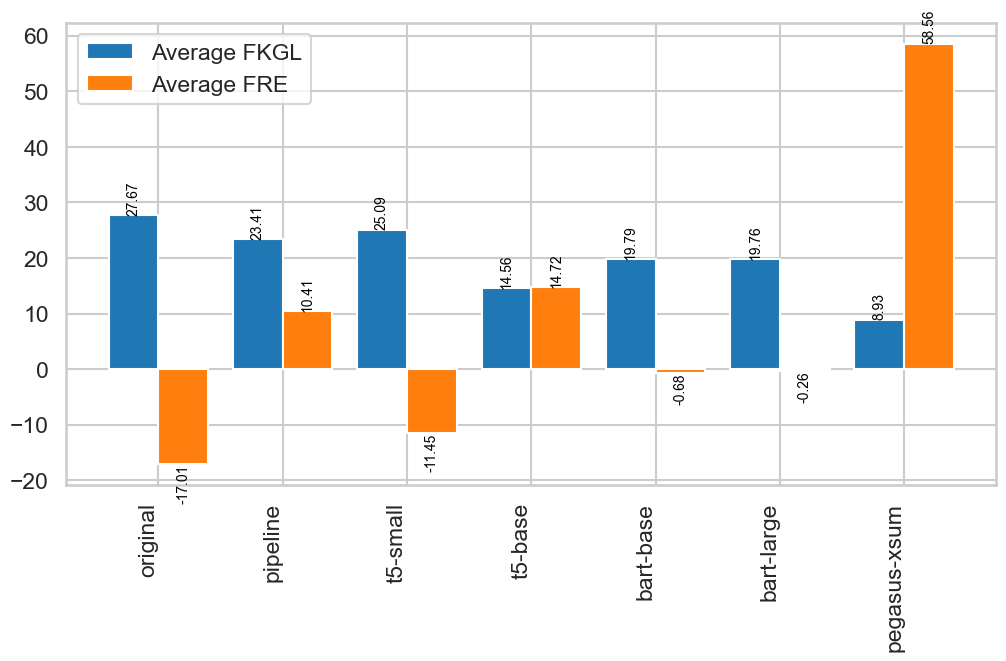

In [ ]:
names = ['original', 'pipeline', 't5-small', 't5-base', 'bart-base', 'bart-large', 'pegasus-xsum']

x_axis = np.arange(len(names))

fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.4

ax.bar(x_axis - bar_width / 2, all_fkgl_means, width=bar_width, label='Average FKGL')
ax.bar(x_axis + bar_width / 2, all_fre_means, width=bar_width, label='Average FRE')

ax.set_xticks(x_axis)
ax.set_xticklabels(names, rotation=90, ha='right')

for container in ax.containers:
    ax.bar_label(
        container, 
        labels=[f'{v:.2f}' for v in container.datavalues],
        label_type='center', 
        rotation=90, 
        color='black', 
        fontsize=10
    )

ax.legend()
plt.savefig('models_comparison_v3.png', dpi=300, bbox_inches='tight')
plt.show()
